In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Соревнование по распознаванию объектов на изображениях из набора данных CIFAR-10

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow.nn import fractional_max_pool
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Add, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Layer, Activation, GlobalAveragePooling2D, ZeroPadding2D, AveragePooling2D, Lambda
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import glorot_uniform
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras import backend as K
import pickle
from scipy.misc import toimage
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, space_eval
import random
import os

%matplotlib inline 

In [0]:
# Размер мини-выборки
batch_size = 128
# Количество классов изображений
nb_classes = 10
# Названия классов из набора данных CIFAR-10
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

## Настраиваем Kaggle API

In [0]:
!mkdir ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle
!ls ~/.kaggle

kaggle.json


In [0]:
!ls

## Загружаем данные с сайта Kaggle

In [0]:
!kaggle competitions download -c nu-cifar10-spring2019
!unzip test.npy.zip 
!unzip train.npz.zip

#!mv test.npy /content/drive/My\ Drive/test.npy
#!mv train.npz /content/drive/My\ Drive/train.npz


test.npy.zip: Skipping, found more recently modified local copy (use --force to force download)
train.npz.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
Archive:  test.npy.zip
  inflating: test.npy                
Archive:  train.npz.zip
  inflating: train.npz               


In [0]:
nb_classes = 10
data = np.load('/content/drive/My Drive/train.npz')
x_train = data['x']
y_train = utils.to_categorical(data['y'], nb_classes)

x_test = np.load('/content/drive/My Drive/test.npy') 

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
#x_train = (x_train-mean)/(std+1e-7)
#x_test = (x_test-mean)/(std+1e-7)
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std


In [0]:
print(np.mean(x_train))
print(mean)

-2.900198599794142e-17
120.70756512369792


#Обучение сети

In [0]:
%%time 

сheckpoint = ModelCheckpoint('cifar-cnn.hdf5', 
                                monitor='val_categorical_accuracy', 
                                save_best_only=True,
                                verbose=0)

def frac_max_pool(x):
    return fractional_max_pool(value=x,pooling_ratio = [1.,1.414,1.414,1.])[0]
  
def callbacks():
  сheckpoint = ModelCheckpoint('cifar-cnn.hdf5', 
                                monitor='val_categorical_accuracy', 
                                save_best_only=True,
                                verbose=0)
  
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                              patience=3, 
                                              verbose=0, 
                                              factor=0.5, 
                                              min_lr=0.00001)
  
  earlystop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=20,verbose=0, mode='auto')
  
  return [сheckpoint,learning_rate_reduction,earlystop]

#модель
def create_model(params,comp=True): 
  input_shape=(32,32,3)
  X_input = Input(input_shape)  
  
  #1 слой свертки
  x = Conv2D(params['filters'], (3,3), padding='same', activation=params['activation'])(X_input)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = Conv2D(params['filters'], (3,3), padding='same', activation=params['activation'])(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  
  x_shortcut = x 
  
  #2 слой свертки
  x = Conv2D(3*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)  
  x = Conv2D(3*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  
  x = MaxPooling2D(pool_size=(2,2))(x)
  
  #сопоставления размерностей
  x_shortcut = Conv2D(filters = 3*params['filters'], kernel_size = (1, 1), strides = (2,2), padding = 'same', activation=params['activation'])(x_shortcut)
  x_shortcut = BatchNormalization(axis = 3)(x_shortcut)

  #Соединения быстрого доступа (shortcut connections)
  x = Add()([x, x_shortcut])
  x = Activation(params['activation'])(x)

  x_shortcut = x 
  #3 слой свертки
  x = Conv2D(4*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = Conv2D(4*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  
  #сопоставления размерностей
  x_shortcut = Conv2D(filters = 4*params['filters'], kernel_size = (1, 1), strides = (2,2), padding = 'same', activation=params['activation'])(x_shortcut)
  x_shortcut = BatchNormalization(axis = 3)(x_shortcut)
  
  #Соединения быстрого доступа (shortcut connections)
  x = Add()([x, x_shortcut])
  x = Activation(params['activation'])(x)
  
  #выходной слой
  x = AveragePooling2D((2,2), name="avg_pool")(x)
  x = Dropout(params['drop'])(x)    
  x = Flatten()(x)  
  #x = GlobalAveragePooling2D()(x)
    
  x = Dense(params['units'], activation=params['activation'])(x)
  x = Dense(params['units'], activation=params['activation'])(x)
  x = Dropout(params['drop'])(x)
  x = Dense(nb_classes, activation='softmax')(x)
  model = Model(inputs = X_input, outputs = x)  
  
  if comp==True:
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
  return(model)

weight_decay = 1e-4
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=random_seed)


params = {'activation': 'elu', 'batch_size': 128, 'drop': 0.4, 'units': 768, 'momentum': 0.8, 'filters':256}
batch_size = params['batch_size']
model = create_model(params)

datagen = ImageDataGenerator(
      featurewise_center=False, # set input mean to 0 over the dataset
      samplewise_center=False,  # set each sample mean to 0
      featurewise_std_normalization=False,  # divide inputs by std of the dataset
      samplewise_std_normalization=False,  # divide each input by its std
      zca_whitening=False,  # apply ZCA whitening
      rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
      zoom_range = 0.1, # Randomly zoom image 
      width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
      height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
      horizontal_flip=True,  # randomly flip images
      vertical_flip=False,  # randomly flip images
      fill_mode='reflect')#,
      #validation_split=0.1)
datagen.fit(X_train)

history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                  steps_per_epoch=X_train.shape[0] // batch_size,
                  epochs=100,
                  validation_data=(X_val,Y_val),
                  #validation_split=0.2,
                  verbose=1,
                  callbacks = callbacks())

np.max(history.history['val_categorical_accuracy'])    


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
313/313 [==============================] - 216s 690ms/step - loss: 2.7049 - categorical_accuracy: 0.3460 - val_loss: 1.6757 - val_categorical_accuracy: 0.5138
Epoch 2/100
313/313 [==============================] - 197s 628ms/step - loss: 1.6370 - categorical_accuracy: 0.5364 - val_loss: 1.3020 - val_categorical_accuracy: 0.6374
Epoch 3/100
313/313 [==============================] - 196s 625ms/step - loss: 1.3135 - categorical_accuracy: 0.6388 - val_loss: 1.2245 - val_categorical_accuracy: 0.6709
Epoch 4/100
313/313 [==============================] - 195s 623ms/step - loss: 1.1813 - categorical_accuracy: 0.6919 - val_loss: 1.0829 - val_categorical_accuracy: 0.7380
Epoch 5/100
313/313 [==============================] - 194s 620ms/step - loss: 1.

In [0]:
#дообучим сеть с добавлением отрицательно распознанных примеров
from tensorflow.keras.optimizers import SGD

#генератор добавляет отрицательные примеры
def image_generator():    
  while True:    
    batch = batches.next()

    yield( np.vstack((batch[0],X_fp_train)), np.vstack((batch[1],Y_fp_train)) )


model = create_model(params,False)
opt = SGD(lr=.00001, momentum=.9)        
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])    
model.load_weights('cifar-cnn.hdf5')


сheckpoint = ModelCheckpoint('cifar-cnn.hdf5', 
                                monitor='val_categorical_accuracy', 
                                save_best_only=True,
                                verbose=0)

batches = datagen.flow(X_train, Y_train, batch_size=batch_size)        

for i in range(10):
  
  #отрицательные предсказания
  predictions = model.predict(X_train)
  predictions = np.argmax(predictions, axis=1)

  tru = np.argmax(Y_train, axis=1)
  idx = np.where(tru!=predictions)

  X_fp_train = X_train[idx]
  Y_fp_train = Y_train[idx]


  history = model.fit(image_generator(), 
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=1,
                    validation_data=(X_val,Y_val),
                    #validation_split=0.2,
                    verbose=1,
                    callbacks = [сheckpoint])
            


312/312 [==============================] - 204s 655ms/step - loss: 0.2270 - categorical_accuracy: 0.9924 - val_loss: 0.5315 - val_categorical_accuracy: 0.9328


'\ni = 0\nfor batch in datagen.flow(X_train, Y_train, batch_size=batch_size):\n    i += 1\n    model.fit(np.vstack((batch[0],X_fp_train)), np.vstack((batch[1],Y_fp_train)), \n                  epochs=1,\n                  validation_data=(X_val,Y_val),\n                  #validation_split=0.2,\n                  verbose=1,\n                  callbacks=[сheckpoint])\n\n    if i > 25:\n        break  # otherwise the generator would loop indefinitely\n        \n\nhistory = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size)+(X_fp_train,Y_fp_train), \n                  steps_per_epoch=X_train.shape[0] // batch_size,\n                  epochs=1,\n                  validation_data=(X_val,Y_val),\n                  #validation_split=0.2,\n                  verbose=1,\n                  callbacks = callbacks())\n'

In [0]:
model.load_weights('cifar-cnn.hdf5')
score = model.evaluate(X_val, Y_val, verbose=0)
validation_acc = score[1]
print('validation acc:', validation_acc)

validation acc: 0.9337


#Визуализация модели

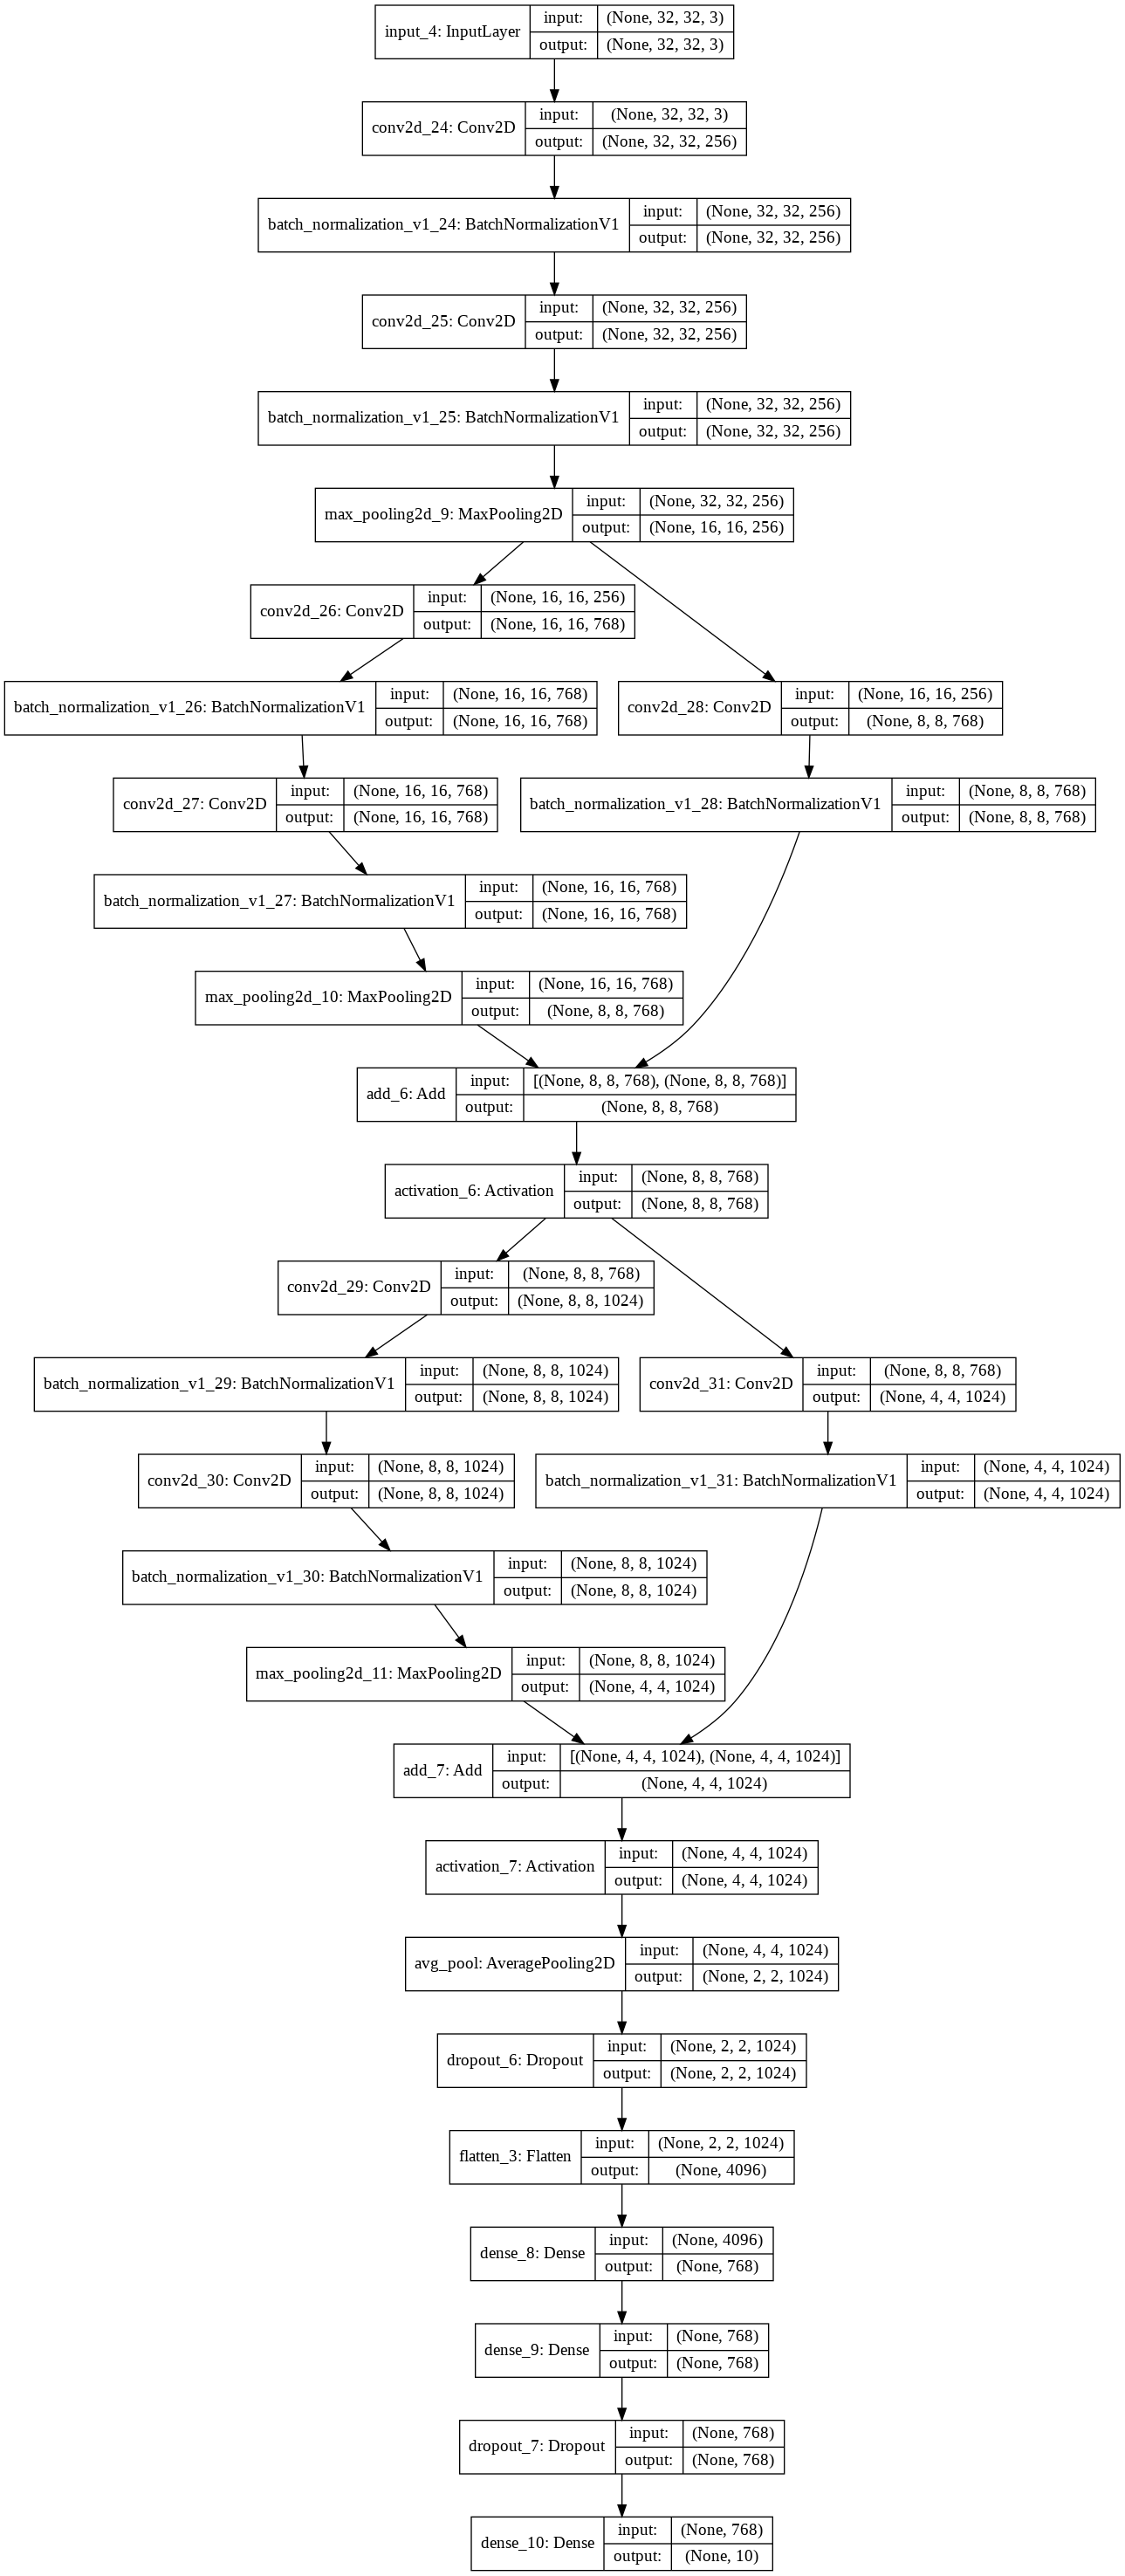

In [7]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image


model = create_model(params)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image('model_plot.png')

#Визуализация качества обучения

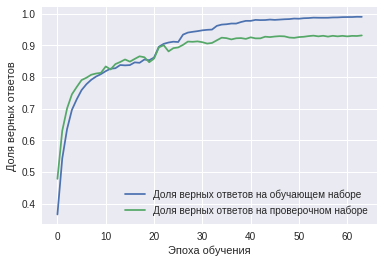

In [0]:
plt.plot(history.history['categorical_accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_categorical_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#Отправка решения на Kaggle

In [0]:
#model = create_model8()
model.load_weights('cifar-cnn.hdf5')

score = model.evaluate(X_val, Y_val, verbose=0)
validation_acc = score[1]
print('validation acc:', validation_acc)

predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)

out = np.column_stack((range(1, predictions.shape[0]+1), predictions))
np.savetxt('submission.csv', out, header="Id,Category", comments="", fmt="%d,%d")

!head submission.csv

!kaggle competitions submit -c nu-cifar10-spring2019 -m "Submition from Colab val: 0.9337" -f submission.csv
#files.download('submission.csv')


validation acc: 0.9335
Id,Category
1,5
2,7
3,8
4,4
5,6
6,9
7,3
8,1
9,9
100% 67.3k/67.3k [00:01<00:00, 47.0kB/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.3', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 64, in main
    print(out, end='')
UnicodeEncodeError: 'latin-1' codec can't encode characters in position 26-38: ordinal not in range(256)
